### Classification and Quantitative Analysis (1) | FORUMS.RED 

This notebook implements a rule-based keyword classifier to label threads with three core discourse themes:
Masculinity Guidance, Market Logic of Sexual Worth, Resistance to Financially Motivated Attraction

We applied the classifier to full discussion threads (post + comments). A thread was labeled if any part matched the keyword set, reflecting how readers encounter themes in forum discourse. Threads may match multiple themes.

In [49]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import itertools
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import matplotlib.patches as patches

In [14]:
import plotly.graph_objects as go

In [2]:
anti_provisioning_keywords = ["beta bucks", "provisioning", "beta bux", "beta buxx", "gold digger", "golddigger", "betabux", "betabuxx", 
                                                "provision", "provider", "sugar daddy", "sugardaddy", "prenup", "child support", "alimony", "anchor baby"]

market_logic_keywords = ["smv", "sexual market value", "high value", "/10", "low value", "top 10", "top 20", "top 15" "top 30", 
                        "2s", "3s", "4s", "5s", "6s", "7s", "8s", "9s", "10s", "his league", "her league", "your league", "out of 10", "out of ten"]

guidance_keywords = ["self-improvement", "self improvement", "dating", "status", "fitness", "grooming", "frame", "alpha", "discipline", "mission", "shit test"]


In [3]:
df = pd.read_csv('all_posts_comments.csv')

In [4]:
anti_provisioning_keywords_pattern = '|'.join(anti_provisioning_keywords)
market_logic_keywords_pattern = '|'.join(market_logic_keywords)
guidance_keywords_pattern = '|'.join(guidance_keywords)

In [5]:
# Add binary columns based on keyword pattern matches
df['anti_provisioning_match'] = df['full_text'].str.contains(anti_provisioning_keywords_pattern, case=False, na=False).astype(int)

df['market_logic_match'] = df['full_text'].str.contains(market_logic_keywords_pattern, case=False, na=False).astype(int)

df['guidance_match'] = df['full_text'].str.contains(guidance_keywords_pattern, case=False, na=False).astype(int)


In [6]:
def bucket_years_ago(s):
    if pd.isna(s):
        return np.nan
    s = s.strip().lower()
    if s.endswith("ago"):
        s = s.replace("ago", "").strip()

    try:
        if "y" in s:
            return int(s.replace("y", ""))
        elif "m" in s or "d" in s or "w" in s:
            return 0  # Less than 1 year
        else:
            return np.nan
    except:
        return np.nan

In [7]:
df['years_ago_bucket'] = df['time_since'].apply(bucket_years_ago)

In [8]:
len(df)

12317

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12317 entries, 0 to 12316
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_id                  12317 non-null  int64  
 1   time_since               12317 non-null  object 
 2   flair_nr                 12317 non-null  int64  
 3   post_views               12317 non-null  int64  
 4   score                    12317 non-null  int64  
 5   full_text                12317 non-null  object 
 6   days_ago                 11704 non-null  float64
 7   tokens                   12317 non-null  object 
 8   comment_count            12317 non-null  int64  
 9   anti_provisioning_match  12317 non-null  int64  
 10  market_logic_match       12317 non-null  int64  
 11  guidance_match           12317 non-null  int64  
 12  years_ago_bucket         12317 non-null  int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 1.2+ MB


In [33]:
# Step 1: Define the binary match columns
match_cols = ['anti_provisioning_match', 'market_logic_match', 'guidance_match']

# Step 2: Melt the DataFrame to long format for analysis
df_melted = df.melt(
    id_vars=['post_views', 'score', 'days_ago', 'comment_count'],
    value_vars=match_cols,
    var_name='match_type',
    value_name='match_value'
)

# Step 3: Keep only rows where the match_value is 1
df_matched = df_melted[df_melted['match_value'] == 1]

print(df_matched['match_type'].value_counts())

# Step 4: Aggregate post_views, score, days_ago, comment_count by match_type
agg_table = df_matched.groupby('match_type')[['post_views', 'score', 'days_ago', 'comment_count']].agg(
    ['sum', 'mean', 'median','max','min']
).round(2)

match_type
guidance_match             8171
market_logic_match         3755
anti_provisioning_match    1796
Name: count, dtype: int64


In [32]:
# Define match columns and metrics
match_cols = ['anti_provisioning_match', 'market_logic_match', 'guidance_match']
metrics = ['post_views', 'score', 'days_ago', 'comment_count']

results = []

for col in match_cols:
    filtered = df[df[col] == 1]
    agg = filtered[metrics].agg(['sum', 'mean', 'median','max','min']).T
    agg['match_type'] = col
    agg['metric'] = agg.index  # Keep track of which metric this is
    results.append(agg)

# Combine and organize the output
agg_table = pd.concat(results)
agg_table = agg_table.set_index(['match_type', 'metric']).round(2)

# Show the clean table
agg_table

sum     mean  median  \
match_type              metric                                       
anti_provisioning_match post_views     17274867.0  9618.52  1000.0   
                        score            172750.0    96.19    19.0   
                        days_ago        2416672.0  1402.60  1460.0   
                        comment_count     92949.0    51.75    23.0   
market_logic_match      post_views     19326070.0  5146.76   743.0   
                        score            279845.0    74.53     3.0   
                        days_ago        4819589.0  1351.16  1095.0   
                        comment_count    140827.0    37.50    16.0   
guidance_match          post_views     23236020.0  2843.72   571.0   
                        score            414741.0    50.76     2.0   
                        days_ago       10009011.0  1293.66  1095.0   
                        comment_count    205722.0    25.18    12.0   

                                              max   min  
match_type              metric                           
anti_provisioning_match post_views     13600000.0  24.0  
                        score              1600.0  -9.0  
                        days_ago           2190.0   7.0  
                        comment_count       969.0   0.0  
market_logic_match      post_views     13600000.0  14.0  
                        score              2300.0 -17.0  
                        days_ago           2190.0   1.0  
                        comment_count       969.0   0.0  
guidance_match          post_views     13600000.0  11.0  
                        score              2300.0 -17.0  
                        days_ago           2190.0   1.0  
                        comment_count       969.0   0.0

In [30]:
df['years_ago_bucket'].value_counts().sort_index()


years_ago_bucket
0     651
1    1186
2    1889
3    4378
4     929
5     868
6    2416
Name: count, dtype: int64

In [31]:
df['years_ago_bucket'].unique()


array([0, 1, 2, 4, 3, 5, 6])

In [ ]:
# WE NEED TO GET THE ACCURACY SCORE FOR EACH OF OUR CLASSIFIERS/TOPICS

In [38]:
# Drop NaNs to avoid errors
view_df = df.dropna(subset=['years_ago_bucket', 'post_views'])

# Calculate average views per year
avg_views_per_year = view_df.groupby('years_ago_bucket')['post_views'].median().sort_index()

# Display
print(avg_views_per_year)


years_ago_bucket
0    1300.0
1    1200.0
2     824.0
3     279.0
4     307.0
5     530.0
6     164.0
Name: post_views, dtype: float64


In [39]:
len(view_df)

12317

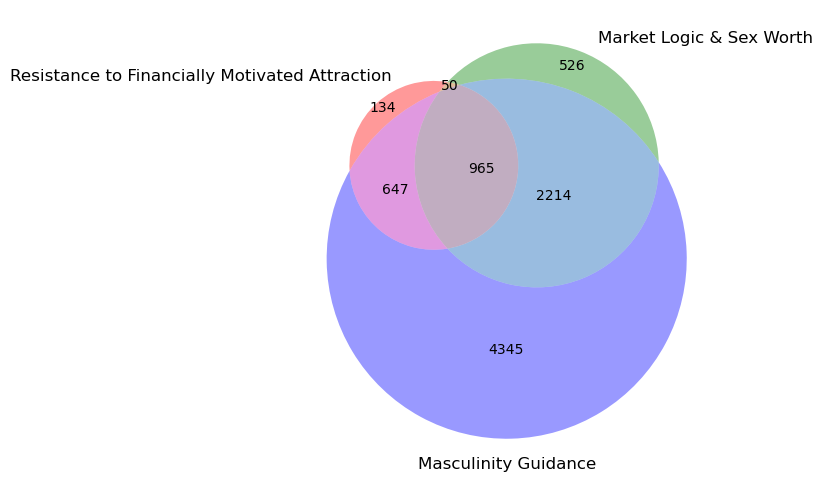

In [52]:
# Count how many posts fall into each theme combination
A = df['anti_provisioning_match'] == 1
B = df['market_logic_match'] == 1
C = df['guidance_match'] == 1

# Build the Venn counts
venn_counts = {
    '100': ((A) & (~B) & (~C)).sum(),
    '010': ((~A) & (B) & (~C)).sum(),
    '001': ((~A) & (~B) & (C)).sum(),
    '110': ((A) & (B) & (~C)).sum(),
    '101': ((A) & (~B) & (C)).sum(),
    '011': ((~A) & (B) & (C)).sum(),
    '111': ((A) & (B) & (C)).sum(),
}

# Plot
plt.figure(figsize=(8, 6))
v = venn3(
    subsets=venn_counts,
    set_labels=(
        theme_display['anti_provisioning_match'],
        theme_display['market_logic_match'],
        theme_display['guidance_match']
    )
)


In [30]:
# Define your binary match columns
match_cols = ['anti_provisioning_match', 'market_logic_match', 'guidance_match']

# Find rows where all match columns are 0
unclassified = df[(df[match_cols] == 0).all(axis=1)]

# Count of unclassified posts
unclassified_count = unclassified.shape[0]
print(f"Number of unclassified posts: {unclassified_count}")

Number of unclassified posts: 3436
